<img src=docs/tudelft_logo.jpg width=50%>

## Data-driven Design and Analyses of Structures and Materials (3dasm)

## Lecture 12

### Miguel A. Bessa | <a href = "mailto: M.A.Bessa@tudelft.nl">M.A.Bessa@tudelft.nl</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.
* Creating a new StandardScaler for Gaussian Processes: https://stats.stackexchange.com/questions/364418/how-to-get-the-prediction-std-using-gaussian-process-in-scikit-learn
* The flower to explain the Iris dataset comes from this [source](https://www.ritchieng.com/machine-learning-iris-dataset/)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the 3dasm conda environment (see Lecture 1).

2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
conda activate 3dasm
jupyter notebook
```
4. Open notebook of this Lecture.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
#plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Continuation of tutorial on supervised learning (again, no theory today!)
    - Multidimensional regression with Gaussian Processes and Artificial Neural Networks
* Classification with supervised learning: quick tutorial using Decision Trees and Support Vector Machines

**Reading material**: This notebook + (GPs in Section 17.3 of book; ANNs in Chapter 13)

## Today's lecture is also going to be more practical

Similarly to the previous lecture, we will focus on the practical aspects **without deriving the models yet**.

* We will continue to focus on regression via supervised learning with the same methods but now considering multiple dimensions:
    - **Gaussin Processes** using [scikit-learn](https://scikit-learn.org)
    - **Artificial Neural Networks** (ANNs) using [keras](https://keras.io/) and [tensorflow](https://www.tensorflow.org/)
* We will also do a quick example on classification via supervised learning with:
    - **Decision trees** using [scikit-learn](https://scikit-learn.org)
    - **Support vector machines** using [scikit-learn](https://scikit-learn.org)

Remember: there are many (many!) more ML models out there. We are covering a few simple ones... The hope is that you feel comfortable with applying and deriving different models!

# 1. Multidimensional regression

Similarly to what we did for one-dimension, now we are going to show how to do multidimensional regression with supervised learning.

As you will see, it's pretty much the same thing...

* We will use less obvious functions to generate our datasets for subsequent learning.


* There is a nice website listing many different benchmark functions used in optimization: https://www.sfu.ca/~ssurjano/optimization.html

Let's try to learn some of them...

In [2]:
# Line below is to enable live rotation of the surface plots.
%matplotlib notebook
#
from matplotlib import cm # to change colors of surface plots
# Set the color scheme used in every plot:
set_cm = cm.cool # viridis, inferno, copper, PuBu, cool, coolwarm, hsv
#
seed = 1987 # set a random seed to replicate results
np.random.seed(seed)

In [3]:
import pandas as pd
# read pandas DataFrame from "docs" folder of the past Lecture
df = pd.read_pickle("../Lecture11/docs/data_noiseless_schwefel_2D_regression.pkl")
function_name = 'Schwefel' # The dataframe was created using the Schwefel function

print("Show that this is the same DataFrame as in Lecture 11:\n", df)

Show that this is the same DataFrame as in Lecture 11:
              x1    x2          y1
0    -10.000000 -10.0  837.552129
1     -9.591837 -10.0  838.185887
2     -9.183673 -10.0  838.777493
3     -8.775510 -10.0  839.323512
4     -8.367347 -10.0  839.820614
...         ...   ...         ...
2495   8.367347  10.0  836.110986
2496   8.775510  10.0  836.608088
2497   9.183673  10.0  837.154107
2498   9.591837  10.0  837.745713
2499  10.000000  10.0  838.379471

[2500 rows x 3 columns]


Considering the same dataset as in the previous lecture, we then:

* Split the data into the same training and testing sets as in Lecture 11.

* Scale the data using the same StandardScaler from scikit-learn.

(Since this is the same code as used in the previous lecture, it is only shown below as notes)

<IPython.core.display.Javascript object>


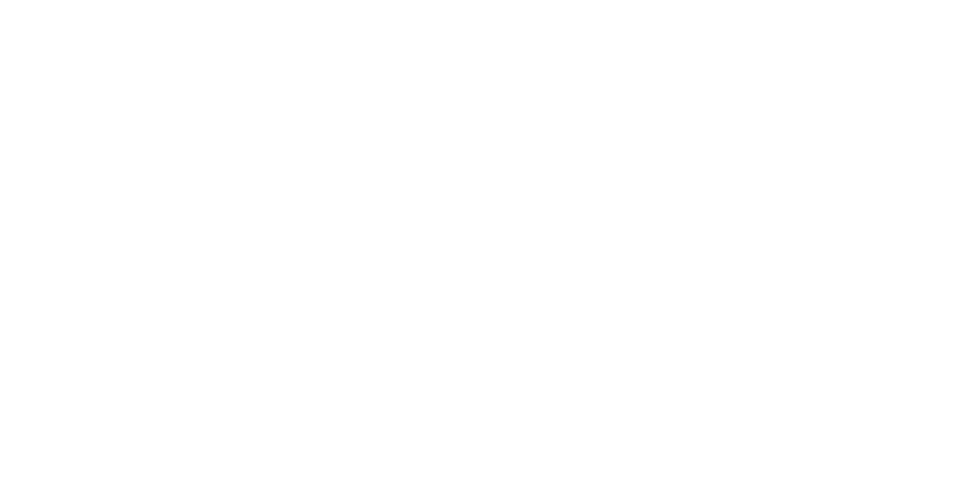

In [4]:
# Separate the features and targets into two different variables:
X_data = df.loc[:,['x1','x2']].values # note that we ask for all the values, not a subset of the DataFrame
y_data = df.loc[:,'y1'].values

# Recreate the grid of points that is necessary to plot surfaces (by reshaping)
X1_grid = np.reshape(X_data[:,0],( round( np.sqrt(len(X_data)) ), round( np.sqrt(len(X_data)) ) ))
X2_grid = np.reshape(X_data[:,1],( round( np.sqrt(len(X_data)) ), round( np.sqrt(len(X_data)) ) ))
Y_grid = np.reshape(y_data,( round( np.sqrt(len(X_data)) ), round( np.sqrt(len(X_data)) ) ))

# Train/test split like we did before!
from sklearn.model_selection import train_test_split

testset_ratio = 0.98 # ratio of test set points from the dataset

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=testset_ratio,random_state=seed)

from sklearn.preprocessing import StandardScaler
# Scaling inputs with a Standard Scaler:
scaler_x = StandardScaler()
scaler_x.fit(X_train) # fit the scaler to the input data
#
X_train_scaled=scaler_x.transform(X_train) # scale the input training data
X_test_scaled=scaler_x.transform(X_test)  # scale the input testing data
X_data_scaled=scaler_x.transform(X_data) # scale the input data (the whole dataset)

# Now scaling outputs also using StandardScaler:
y_train = y_train.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
y_test = y_test.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
y_data = y_data.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#
scaler_y = StandardScaler()
scaler_y.fit(y_train) # fit the scaler to the output data
#
y_train_scaled=scaler_y.transform(y_train) # scale the output training data
y_test_scaled=scaler_y.transform(y_test)  # scale the output testing data
y_data_scaled=scaler_y.transform(y_data) # scale the output data (the whole dataset)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel
# Create GP model as we did in the previous Lecture.
kernel = ConstantKernel(1.0, (1e-4, 1e4)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20) # using a small alpha

# The ONLY difference is that we will train the model on SCALED inputs and outputs
gp_model.fit(X_train_scaled, y_train_scaled) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting), both for mean and standard deviation
y_data_GPpred_scaled, sigma_data_GPpred_scaled = gp_model.predict(X_data_scaled, return_std=True)
# IMPORTANT: we need to scale the predictions for the mean of the output back to the original scale!
y_data_GPpred = scaler_y.inverse_transform(y_data_GPpred_scaled) # mean
# IMPORTANT: we need to do the same for the standard deviation of the output, but in this case we have to subtract
#            by the mean of the training data because the standard deviation is not transformed by the
#            StandardScaler in the same way as the mean! In the Homework you will derive this...
sigma_data_GPpred = scaler_y.inverse_transform(sigma_data_GPpred_scaled.reshape(-1, 1)) - np.mean(y_train)
my_sigma_data_GPpred = sigma_data_GPpred_scaled.reshape(-1, 1)*np.std(y_train)

# Predict for test set (for error metric)
y_test_GPpred_scaled, sigma_test_GPpred_scaled = gp_model.predict(X_test_scaled, return_std=True)
# Scale mean and std back, as above.
y_test_GPpred = scaler_y.inverse_transform(y_test_GPpred_scaled)
sigma_test_GPpred = scaler_y.inverse_transform(sigma_test_GPpred_scaled.reshape(-1, 1)) - np.mean(y_train)

fig3 = plt.figure(figsize=plt.figaspect(0.5)); ax3 = []
# Subplot 1 (left): ground truth
ax3.append(fig3.add_subplot(1, 2, 1, projection='3d'))
surf = ax3[0].plot_surface(X1_grid, X2_grid, Y_grid,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3[0].set_xlabel('$x_1$', fontsize=15)
ax3[0].set_ylabel('$x_2$', fontsize=15)
ax3[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# Subplot 2 (right): GPR approximation
ax3.append(fig3.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax3[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                                       cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3[1].set_xlabel('$x_1$', fontsize=15)
ax3[1].set_ylabel('$x_2$', fontsize=15)
ax3[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax3[1].scatter(X_train[:,0], X_train[:,1], y_train, marker='o', color='red', label="training points")
ax3[1].legend(loc='upper center')
#plt.tight_layout()
plt.close(fig3) # close figure to open it in next cell.

<IPython.core.display.Javascript object>


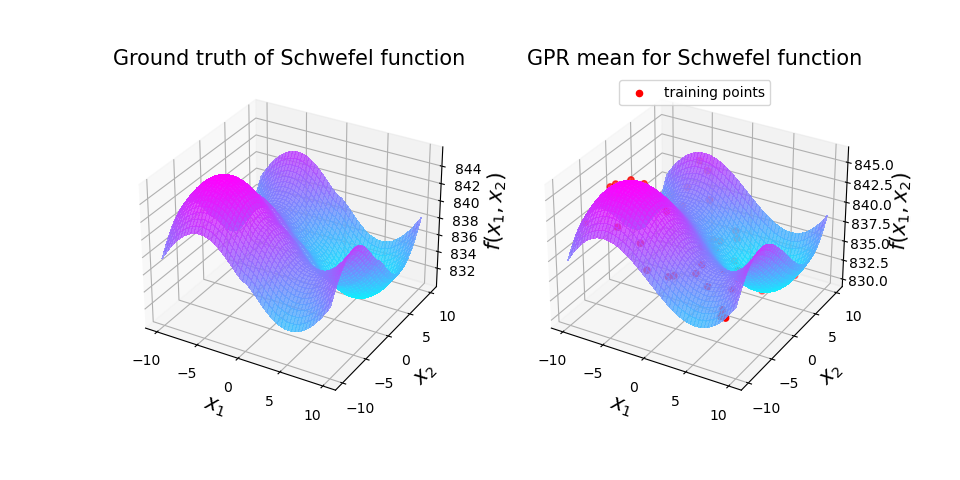

In [5]:
fig3 # show GP prediction for noiseless dataset of Schwefel function obtained in previous Lecture.

This is the prediction we obtained using GPs last Lecture.

## Multidimensional regression with Artificial Neural Networks

Today we will use ANNs to make predictions on the same data considering the same training points.

As we will see, ANNs behave in a somewhat opposite way: training for data scarce problems can be challenging, but ANNs are very scalable for "big data" problems.

Below is a code including an option to perform grid search (or not). The code is basically the same as what we saw in Lecture 10 but now with 2D features.

In [6]:
# As expected, the code for multidimensional ANNs is basically the same as the 1D case.
from tensorflow import keras
from tensorflow.keras.optimizers import Adam # import the optimizer you want to use to calculate the parameters
from keras.models import Sequential # to create a feedforward neural network
from keras.layers.core import Dense # to create a feedforward neural network with dense layers
from keras.wrappers.scikit_learn import KerasRegressor # a new version will use scikeras
from keras.callbacks import EarlyStopping # a strategy for complexity control
from sklearn.model_selection import GridSearchCV # simple (brute force) approach to find better hyperparameters.
#
# Function to create the ANN model
def create_ANN(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    #model.add(Dense(neurons3, activation=activation)) # thrid hidden layer
    #model.add(Dense(neurons4, activation=activation)) # fourth hidden layer, etc.
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model
#

In [7]:
# If you don't want to use Early Stopping, then comment the command below.
early_stopping = EarlyStopping(monitor='val_loss', # use validation error to check if training should stop early
                               min_delta=0.0, # minimum change in the monitored quantity to qualify as an
                                              # improvement (if 0, then even small improvements count)
                               patience=30, # be patient for a few epochs to verify evolution of loss
                               mode='min') # in min mode, training stops when val_loss stops decreasing
# Summary of this early_stopping criterion:
# stop training when there is no improvement in the loss for 30 consecutive epochs.

neurons1=200 # number of neurons in hidden layer 1
neurons2=10  # number of neurons in hidden layer 2
epochs = 1000 # number of epochs
batch_size = len(X_train) # number of samples in each batch
optimizer = 'adam' # optimizer
ANN_model = KerasRegressor(build_fn=create_ANN, # the function where we define our ANN
                           input_dimensions=np.shape(X_train)[1], # the input dimensions (here it is 2)
                           neurons1=neurons1, # number of neurons in the first hidden layer
                           neurons2=neurons2, # number of neurons in the second hidden layer
                           batch_size=batch_size, # define the number of samples in each batch
                           epochs=epochs, # number of epochs
                           optimizer=optimizer, # optimizer
                           callbacks=[early_stopping], # include early stopping
                           validation_data=(X_test_scaled, y_test_scaled)) # validation data to compute loss
# Train the model:
history = ANN_model.fit(X_train_scaled, y_train_scaled)

/tmp/ipykernel_58479/2277623882.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ANN_model = KerasRegressor(build_fn=create_ANN, # the function where we define our ANN
2022-03-17 15:38:47.481946: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-17 15:38:47.954596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2983 MB memory:  -> device: 0, name: Quadro M2000, pci bus id: 0000:03:00.0, compute capability: 5.2


Epoch 1/1000
1/1 [==============================] - 1s 719ms/step - loss: 1.1202 - val_loss: 1.0339
Epoch 2/1000
1/1 [==============================] - 0s 67ms/step - loss: 1.0599 - val_loss: 0.9757
Epoch 3/1000
1/1 [==============================] - 0s 69ms/step - loss: 1.0017 - val_loss: 0.9230
Epoch 4/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.9489 - val_loss: 0.8778
Epoch 5/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.9035 - val_loss: 0.8414
Epoch 6/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.8691 - val_loss: 0.8123
Epoch 7/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.8411 - val_loss: 0.7860
Epoch 8/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.8150 - val_loss: 0.7609
Epoch 9/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.7899 - val_loss: 0.7369
Epoch 10/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.7651 - val_loss: 0.7137
Epoch 11

1/1 [==============================] - 0s 68ms/step - loss: 0.1729 - val_loss: 0.3436
Epoch 84/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.1716 - val_loss: 0.3418
Epoch 85/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.1702 - val_loss: 0.3399
Epoch 86/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.1689 - val_loss: 0.3379
Epoch 87/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.1676 - val_loss: 0.3356
Epoch 88/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.1662 - val_loss: 0.3329
Epoch 89/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.1647 - val_loss: 0.3301
Epoch 90/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.1632 - val_loss: 0.3273
Epoch 91/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.1617 - val_loss: 0.3246
Epoch 92/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.1602 - val_loss: 0.3222
Epoch 93/1000


1/1 [==============================] - 0s 75ms/step - loss: 0.0950 - val_loss: 0.2492
Epoch 165/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0943 - val_loss: 0.2483
Epoch 166/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0937 - val_loss: 0.2474
Epoch 167/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.0930 - val_loss: 0.2465
Epoch 168/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0924 - val_loss: 0.2455
Epoch 169/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.0917 - val_loss: 0.2445
Epoch 170/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0911 - val_loss: 0.2437
Epoch 171/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0904 - val_loss: 0.2428
Epoch 172/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0898 - val_loss: 0.2417
Epoch 173/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0892 - val_loss: 0.2405
Epoch

1/1 [==============================] - 0s 70ms/step - loss: 0.0547 - val_loss: 0.1710
Epoch 246/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0543 - val_loss: 0.1701
Epoch 247/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0540 - val_loss: 0.1692
Epoch 248/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.0537 - val_loss: 0.1684
Epoch 249/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0533 - val_loss: 0.1675
Epoch 250/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0530 - val_loss: 0.1668
Epoch 251/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0526 - val_loss: 0.1661
Epoch 252/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0523 - val_loss: 0.1654
Epoch 253/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0520 - val_loss: 0.1647
Epoch 254/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0516 - val_loss: 0.1639
Epoch

1/1 [==============================] - 0s 71ms/step - loss: 0.0325 - val_loss: 0.1124
Epoch 327/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0324 - val_loss: 0.1117
Epoch 328/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0322 - val_loss: 0.1112
Epoch 329/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0320 - val_loss: 0.1108
Epoch 330/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.0318 - val_loss: 0.1105
Epoch 331/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0316 - val_loss: 0.1102
Epoch 332/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0314 - val_loss: 0.1098
Epoch 333/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.0312 - val_loss: 0.1092
Epoch 334/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0310 - val_loss: 0.1086
Epoch 335/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0309 - val_loss: 0.1079
Epoch

1/1 [==============================] - 0s 64ms/step - loss: 0.0196 - val_loss: 0.0764
Epoch 408/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.0195 - val_loss: 0.0760
Epoch 409/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0194 - val_loss: 0.0756
Epoch 410/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0192 - val_loss: 0.0752
Epoch 411/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0191 - val_loss: 0.0749
Epoch 412/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0190 - val_loss: 0.0746
Epoch 413/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.0188 - val_loss: 0.0742
Epoch 414/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0187 - val_loss: 0.0737
Epoch 415/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.0186 - val_loss: 0.0733
Epoch 416/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0184 - val_loss: 0.0729
Epoch

1/1 [==============================] - 0s 68ms/step - loss: 0.0109 - val_loss: 0.0522
Epoch 489/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0109 - val_loss: 0.0520
Epoch 490/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0108 - val_loss: 0.0518
Epoch 491/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.0107 - val_loss: 0.0516
Epoch 492/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0106 - val_loss: 0.0514
Epoch 493/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0106 - val_loss: 0.0512
Epoch 494/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0105 - val_loss: 0.0509
Epoch 495/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0104 - val_loss: 0.0507
Epoch 496/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0103 - val_loss: 0.0505
Epoch 497/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0103 - val_loss: 0.0503
Epoch

1/1 [==============================] - 0s 70ms/step - loss: 0.0064 - val_loss: 0.0379
Epoch 570/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0064 - val_loss: 0.0378
Epoch 571/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0064 - val_loss: 0.0377
Epoch 572/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0063 - val_loss: 0.0376
Epoch 573/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.0063 - val_loss: 0.0375
Epoch 574/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0063 - val_loss: 0.0374
Epoch 575/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0062 - val_loss: 0.0373
Epoch 576/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0062 - val_loss: 0.0372
Epoch 577/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.0062 - val_loss: 0.0371
Epoch 578/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.0062 - val_loss: 0.0370
Epoch

1/1 [==============================] - 0s 69ms/step - loss: 0.0044 - val_loss: 0.0312
Epoch 651/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0044 - val_loss: 0.0312
Epoch 652/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0044 - val_loss: 0.0311
Epoch 653/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0044 - val_loss: 0.0310
Epoch 654/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.0043 - val_loss: 0.0310
Epoch 655/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.0043 - val_loss: 0.0309
Epoch 656/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0043 - val_loss: 0.0308
Epoch 657/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0043 - val_loss: 0.0308
Epoch 658/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0043 - val_loss: 0.0307
Epoch 659/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0043 - val_loss: 0.0307
Epoch

1/1 [==============================] - 0s 73ms/step - loss: 0.0032 - val_loss: 0.0269
Epoch 732/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0032 - val_loss: 0.0268
Epoch 733/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0032 - val_loss: 0.0267
Epoch 734/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0032 - val_loss: 0.0267
Epoch 735/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0032 - val_loss: 0.0267
Epoch 736/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0032 - val_loss: 0.0266
Epoch 737/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.0032 - val_loss: 0.0266
Epoch 738/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0032 - val_loss: 0.0265
Epoch 739/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.0031 - val_loss: 0.0265
Epoch 740/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0031 - val_loss: 0.0264
Epoch

1/1 [==============================] - 0s 70ms/step - loss: 0.0024 - val_loss: 0.0236
Epoch 813/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0024 - val_loss: 0.0236
Epoch 814/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0024 - val_loss: 0.0235
Epoch 815/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0024 - val_loss: 0.0235
Epoch 816/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0023 - val_loss: 0.0234
Epoch 817/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0023 - val_loss: 0.0234
Epoch 818/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0023 - val_loss: 0.0234
Epoch 819/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0023 - val_loss: 0.0234
Epoch 820/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0023 - val_loss: 0.0233
Epoch 821/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0023 - val_loss: 0.0233
Epoch

1/1 [==============================] - 0s 72ms/step - loss: 0.0017 - val_loss: 0.0214
Epoch 894/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0017 - val_loss: 0.0214
Epoch 895/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0017 - val_loss: 0.0213
Epoch 896/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0017 - val_loss: 0.0213
Epoch 897/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0017 - val_loss: 0.0213
Epoch 898/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0017 - val_loss: 0.0213
Epoch 899/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0017 - val_loss: 0.0213
Epoch 900/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0017 - val_loss: 0.0212
Epoch 901/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0017 - val_loss: 0.0212
Epoch 902/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0017 - val_loss: 0.0212
Epoch

1/1 [==============================] - 0s 73ms/step - loss: 0.0012 - val_loss: 0.0196
Epoch 975/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.0012 - val_loss: 0.0196
Epoch 976/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0012 - val_loss: 0.0196
Epoch 977/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.0012 - val_loss: 0.0196
Epoch 978/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0012 - val_loss: 0.0196
Epoch 979/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0012 - val_loss: 0.0195
Epoch 980/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.0012 - val_loss: 0.0195
Epoch 981/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0012 - val_loss: 0.0195
Epoch 982/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0012 - val_loss: 0.0195
Epoch 983/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0012 - val_loss: 0.0194
Epoch

Below is a code where you can choose to use Grid Search or not by setting gridsearch = 1 or gridsearch = 0, respectively.

Using Grid Search we do a "brute force" search for good hyperparameters. Try it out!

``` python 
from tensorflow import keras
from tensorflow.keras.optimizers import Adam # import the optimizer you want to use to calculate the parameters
from keras.models import Sequential # to create a feedforward neural network
from keras.layers.core import Dense # to create a feedforward neural network with dense layers
from keras.wrappers.scikit_learn import KerasRegressor # a new version will use scikeras
from keras.callbacks import EarlyStopping # a strategy for complexity control
from sklearn.model_selection import GridSearchCV # simple (brute force) approach to find better hyperparameters.
#
# Function to create the ANN model
def create_ANN(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    #model.add(Dense(neurons3, activation=activation)) # thrid hidden layer
    #model.add(Dense(neurons4, activation=activation)) # fourth hidden layer, etc.
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model
#
# Do you want to look for the best parameters for the Neural Network using Grid Search ("brute force")?
gridsearch = 0 # If gridsearch = 1 it can be quite slow!

if gridsearch==1:
    # If you don't want to use Early Stopping, then comment the command below.
    early_stopping = EarlyStopping(monitor='val_loss', # use validation error to check if training should stop early
                                   min_delta=0.0, # minimum change in the monitored quantity to qualify as an
                                                  # improvement (if 0, then even small improvements count)
                                   patience=30, # be patient for a few epochs to verify evolution of loss
                                   mode='min') # in min mode, training stops when val_loss stops decreasing
    # Summary of this early_stopping criterion:
    # stop training when there is no improvement in the loss for 30 consecutive epochs.
    #
    # Define the grid search for hyperparameters. Each veriable is a 1D array whose elements represent a particular
    # choice of value for that hyperparameter. The grid search will then create all possible combinations among
    # the hyperparameters values that are defined below. If you do not want to change the value of a particular
    # hyperparameter you can define a 1D array that only has 1 element.
    neurons1 = [5,20,200] # number of neurons in hidden layer 1
    neurons2 = [5,10] # number of neurons in hidden layer 2 (if present; uncomment in create_ANN function)
    neurons3 = [10] # number of neurons in hidden layer 3 (if present; uncomment in create_ANN function)
    neurons4 = [10] # number of neurons in hidden layer 4 (if present; uncomment in create_ANN function)
    batch_size = [len(X_train)] # number of samples in each batch
    epochs = [1000] # each element in the vector contains the number of epochs that each model should use.
    optimizer = ['adam'] # 
#    optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] # different optimizers
#    init_mode = ['uniform', 'lecun_uniform', 'normal', 'orthogonal', 'zero', 'one', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'] # different weight initialization strategies
    #
    param_grid = dict(batch_size=batch_size, # define the number of samples in each batch
                      epochs=epochs, # total number of epochs
                      neurons1=neurons1, # number of neurons in the first hidden layer
                      neurons2=neurons2, # number of neurons in the second hidden layer
                      #neurons3=neurons3,neurons4=neurons4, # commented out because I am not using them
                      optimizer=optimizer) # optimizer to find the model parameters
    ANN_model = KerasRegressor(build_fn=create_ANN, # the function where we define our ANN
                               input_dimensions=np.shape(X_train)[1]) # the input dimensions (here it is 2)
    grid = GridSearchCV(estimator=ANN_model, # use our ANN regression model
                        param_grid=param_grid, # use a grid of hyperparameters to find the best among the grid.
                        n_jobs=-1, # number of CPUs to use (if n_jobs = -1 then it uses all CPUs)
                        cv=3) # Using cross validation (if cv=3 then uses 3-fold cross validation)
    grid_result = grid.fit(X_train_scaled, y_train_scaled, # training data
                           callbacks=[early_stopping], # include early stopping
                           validation_data=(X_test_scaled, y_test_scaled)) # validation data to compute loss
    # Once every model in the Grid of hyperparameters is trained, then pick the best model and fit it to
    # the entire training set (without considering cross validation, as we did in the grid search).
    history = grid_result.best_estimator_.fit(X_train_scaled, y_train, 
                                              callbacks=[early_stopping],
                                              validation_data=(X_test_scaled,
                                                               y_test_scaled))
    # Summarize results
    print("Best: %f using %s" % (grid_result.best_score_,
                                 grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score'] # mean of the error metric for each Grid point
    stds = grid_result.cv_results_['std_test_score']   # std of the error metric for each Grid point
    params = grid_result.cv_results_['params'] # hyperparameters used in each Grid point
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param)) # print all the hyperparameters used in each Grid point
else: # just use a particular Neural Network of choice
    # If you don't want to use Early Stopping, then comment the command below.
    early_stopping = EarlyStopping(monitor='val_loss', # use validation error to check if training should stop early
                                   min_delta=0.0, # minimum change in the monitored quantity to qualify as an
                                                  # improvement (if 0, then even small improvements count)
                                   patience=30, # be patient for a few epochs to verify evolution of loss
                                   mode='min') # in min mode, training stops when val_loss stops decreasing
    # Summary of this early_stopping criterion:
    # stop training when there is no improvement in the loss for 30 consecutive epochs.
    
    neurons1=200 # number of neurons in hidden layer 1
    neurons2=10  # number of neurons in hidden layer 2
    epochs = 1000 # number of epochs
    batch_size = len(X_train) # number of samples in each batch
    optimizer = 'adam' # optimizer
    ANN_model = KerasRegressor(build_fn=create_ANN, # the function where we define our ANN
                               input_dimensions=np.shape(X_train)[1], # the input dimensions (here it is 2)
                               neurons1=neurons1, # number of neurons in the first hidden layer
                               neurons2=neurons2, # number of neurons in the second hidden layer
                               batch_size=batch_size, # define the number of samples in each batch
                               epochs=epochs, # number of epochs
                               optimizer=optimizer, # optimizer
                               callbacks=[early_stopping], # include early stopping
                               validation_data=(X_test_scaled, y_test_scaled)) # validation data to compute loss
    # Train the model:
    history = ANN_model.fit(X_train_scaled, y_train_scaled)
```

Let's plot the result for ANN as we did for GPR.

<IPython.core.display.Javascript object>


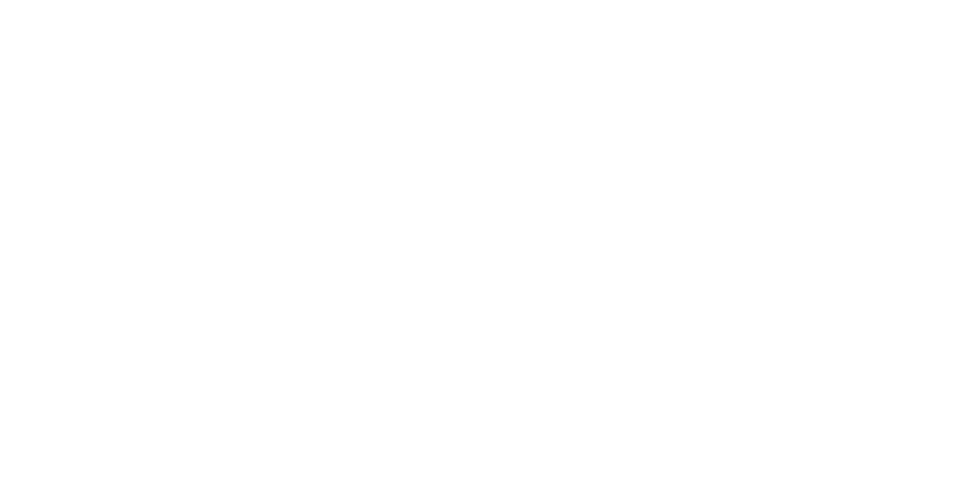

In [8]:
fig5 = plt.figure(figsize=plt.figaspect(0.5)); ax5 = []
#
# Subplot 1 (left): ground truth
ax5.append(fig5.add_subplot(1, 2, 1, projection='3d'))
surf = ax5[0].plot_surface(X1_grid, X2_grid, Y_grid,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax5[0].set_xlabel('$x_1$')
ax5[0].set_ylabel('$x_2$')
ax5[0].set_zlabel('$f(x_1,x_2)$')
ax5[0].set_title("Ground truth of %s function" % function_name)

# Subplot 2 (right): ANN prediction 
ax5.append(fig5.add_subplot(1, 2, 2, projection='3d'))
y_data_ANNpred_scaled = history.model.predict(X_data_scaled)
y_data_ANNpred = scaler_y.inverse_transform(y_data_ANNpred_scaled) # scale predictions back to original scale
Y_grid_data_ANNpred = np.reshape(y_data_ANNpred, np.shape(X1_grid)) # putting targets in grid format for plotting
surf = ax5[1].plot_surface(X1_grid, X2_grid, Y_grid_data_ANNpred,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax5[1].set_xlabel('$x_1$', fontsize=15)
ax5[1].set_ylabel('$x_2$', fontsize=15)
ax5[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax5[1].set_title("ANN approximation of %s function" % function_name, fontsize=15)
ax5[1].scatter(X_train[:,0], X_train[:,1], y_train, marker='o', color='red', label="training points")
ax5[1].legend(loc='lower left', fontsize=15)
#
plt.tight_layout()
plt.close(fig5)

<IPython.core.display.Javascript object>


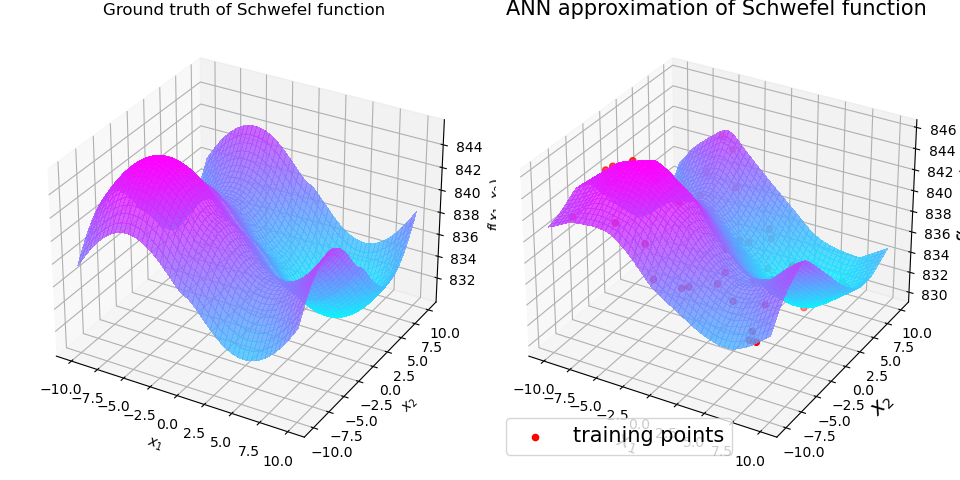

In [9]:
fig5 # surface plots for ANN

The approximation does not seem too bad (and it can get a better!).

* However, it can be challenging to make ANNs as good as GPR for a small number of training points (and there is a theoretical result that explains why!).

Finally, let's calculate the R2 score for the ANN.

In [10]:
from sklearn.metrics import r2_score # Import error metrics
# Compute R2 for the ANN model
y_test_ANNpred_scaled = history.model.predict(X_test_scaled)
y_test_ANNpred = scaler_y.inverse_transform(y_test_ANNpred_scaled) # scale predictions back to original scale

ANN_r2_value = r2_score(y_test, y_test_ANNpred)

print('R2 score for ANN = ', ANN_r2_value)

R2 score for ANN =  0.9806582072505823


In the midterm you will explore training of GPR and ANN using a different number of training points and different hyperparameters.

You will also consider 

For now, let's just see what happens when we consider noise in our dataset.

## 1.3. GPR and ANN with noisy datasets

Since this is so similar to what we did in the 1D case, I will not go through the next cells in detail.

You are encouraged to look into the next cells by yourself (not shown in presentation).

In [11]:
# Create the noisy dataset:
random_std = 0.05+0.1*np.random.random(y_data.shape)
max_diff = np.max(y_data)-np.min(y_data) # magnitude of signal
noise_data = np.random.normal(0,random_std)*max_diff
y_noisy_data = y_data + noise_data # Perturb every y_data point with Gaussian noise

# Pair up points with their associated noise level (because of train_test_split):
Y_noisy_data = np.column_stack((y_noisy_data,noise_data))

# Split into 10% training points and the rest for testing:
X_train, X_test, Y_noisy_train, Y_noisy_test = train_test_split(X_data,
                                    Y_noisy_data, test_size=testset_ratio,
                                    random_state=seed) # "noisy_train" is a great name for a variable, hein?

y_noisy_train = Y_noisy_train[:,0]
noise_train = Y_noisy_train[:,1]
y_noisy_test = Y_noisy_test[:,0]
noise_test = Y_noisy_test[:,1]

# Scaling inputs with a Standard Scaler:
scaler_x = StandardScaler()
scaler_x.fit(X_train)
#
X_train_scaled=scaler_x.transform(X_train)
X_test_scaled=scaler_x.transform(X_test)
X_data_scaled=scaler_x.transform(X_data)

# Scaling outputs with a Standard Scaler:
y_noisy_train = y_noisy_train.reshape(-1, 1)
y_noisy_test = y_noisy_test.reshape(-1, 1)
y_noisy_data = y_noisy_data.reshape(-1, 1)
#
scaler_y = StandardScaler()
scaler_y.fit(y_noisy_train)
#
y_noisy_train_scaled=scaler_y.transform(y_noisy_train)
y_noisy_test_scaled=scaler_y.transform(y_noisy_test)
y_noisy_data_scaled=scaler_y.transform(y_noisy_data)

In [12]:
# Create GP model as we did in the previous Lecture.
kernel = ConstantKernel(1.0, (1e-4, 1e4)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
gp_noisy_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20) # using a small alpha

# The ONLY difference is that we will train the model on SCALED inputs and outputs
gp_noisy_model.fit(X_train_scaled, y_noisy_train_scaled) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting), both for mean and standard deviation
y_noisy_data_GPpred_scaled, sigma_noisy_data_GPpred_scaled = gp_noisy_model.predict(X_data_scaled, return_std=True)
# IMPORTANT: we need to scale the predictions for the mean of the output back to the original scale!
y_noisy_data_GPpred = scaler_y.inverse_transform(y_noisy_data_GPpred_scaled) # mean
# IMPORTANT: we need to do the same for the standard deviation of the output, but in this case we have to subtract
#            by the mean of the training data because the standard deviation is not transformed by the
#            StandardScaler in the same way as the mean! In the Homework you will derive this...
sigma_noisy_data_GPpred = scaler_y.inverse_transform(sigma_noisy_data_GPpred_scaled.reshape(-1, 1)) - np.mean(y_noisy_train)
my_sigma_data_GPpred = sigma_data_GPpred_scaled.reshape(-1, 1)*np.std(y_train)

# Predict for test set (for error metric)
y_noisy_test_GPpred_scaled, sigma_noisy_test_GPpred_scaled = gp_noisy_model.predict(X_test_scaled, return_std=True)
# Scale mean and std back, as above.
y_noisy_test_GPpred = scaler_y.inverse_transform(y_noisy_test_GPpred_scaled)
sigma_noisy_test_GPpred = scaler_y.inverse_transform(sigma_noisy_test_GPpred_scaled.reshape(-1, 1)) - np.mean(y_noisy_train)

<IPython.core.display.Javascript object>


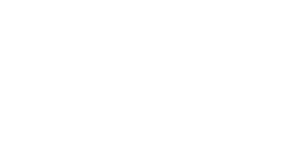

In [13]:
fig6 = plt.figure(figsize=plt.figaspect(0.5)); ax6 = []
ax6.append(fig6.add_subplot(1, 2, 1, projection='3d'))
surf = ax6[0].plot_surface(X1_grid, X2_grid, Y_grid,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax6[0].set_xlabel('$x_1$')
ax6[0].set_ylabel('$x_2$')
ax6[0].set_zlabel('$f(x_1,x_2)$')
ax6[0].set_title("Ground truth of %s function" % function_name)
ax6[0].scatter(X_train[:,0], X_train[:,1], y_noisy_train,
            marker='o', color='red',
           label="training points")
ax6[0].legend(loc='lower left')

# Subplot 2
ax6.append(fig6.add_subplot(1, 2, 2, projection='3d'))
Y_grid_noisy_data_GPpred = np.reshape(y_noisy_data_GPpred, np.shape(X1_grid))
surf = ax6[1].plot_surface(X1_grid, X2_grid, Y_grid_noisy_data_GPpred,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax6[1].set_xlabel('$x_1$')
ax6[1].set_ylabel('$x_2$')
ax6[1].set_zlabel('$f(x_1,x_2)$')
ax6[1].set_title("GPR mean for %s function" % function_name)
ax6[1].scatter(X_train[:,0], X_train[:,1], y_noisy_train,
            marker='o', color='red', label="training points")
ax6[1].legend(loc='lower left')

plt.tight_layout()
plt.close(fig6)

<IPython.core.display.Javascript object>


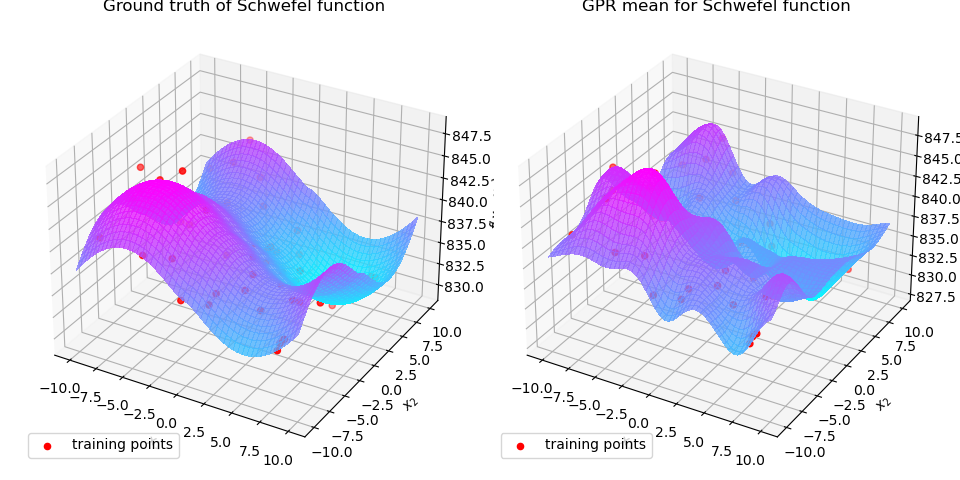

In [14]:
fig6 # plot surfaces

<IPython.core.display.Javascript object>


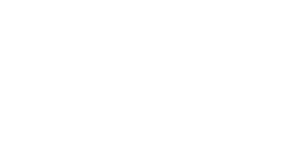

In [15]:
fig7 = plt.figure(figsize=plt.figaspect(0.5)); ax7 = []
# Create Contour plot:
ax7.append(fig7.add_subplot(1, 3, 1))
cset = ax7[0].contourf(X1_grid, X1_grid, Y_grid, cmap=set_cm)
ax7[0].set_xlabel('$x_1$')
ax7[0].set_ylabel('$x_2$')
ax7[0].set_title("Ground truth of %s function" % function_name)
fig7.colorbar(cset, ax=ax7[0])

# Create Contour plot:
ax7.append(fig7.add_subplot(1, 3, 2))
cset = ax7[1].contourf(X1_grid, X2_grid, Y_grid_noisy_data_GPpred,
                       cmap=set_cm)
ax7[1].set_xlabel('$x_1$')
ax7[1].set_ylabel('$x_2$')
ax7[1].set_title("GPR mean for %s function" % function_name)
fig7.colorbar(cset, ax=ax7[1])

# Create Contour plot:
ax7.append(fig7.add_subplot(1, 3, 3))
SIGMA_grid_noisy_data_GPpred = np.reshape(sigma_noisy_data_GPpred, np.shape(X1_grid))
cset = ax7[2].contourf(X1_grid, X2_grid, SIGMA_grid_noisy_data_GPpred,
                       cmap=set_cm)
ax7[2].set_xlabel('$x_1$')
ax7[2].set_ylabel('$x_2$')
ax7[2].set_title("GPR STDV for %s function" % function_name)
fig7.colorbar(cset, ax=ax7[2])

plt.tight_layout()
plt.close(fig7)

<IPython.core.display.Javascript object>


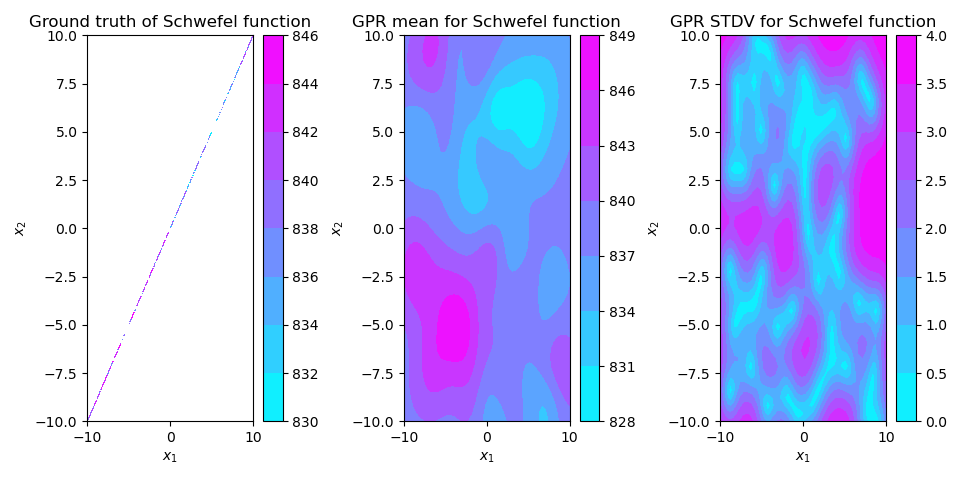

In [16]:
fig7 # plot contours

In [17]:
from sklearn.metrics import r2_score # Import error metrics
# Error metric
# Compute R2 for the GP model
gp_noisy_r2_value = r2_score(y_test, y_noisy_test_GPpred)

print('R2 score for GPR in noisy dataset =', gp_noisy_r2_value)

R2 score for GPR in noisy dataset = 0.7379790005648208


In [18]:
# And now for the ANN:

# Function to create model, required for KerasClassifier when SPECIFYING INPUTS
def create_model(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    #model.add(Dense(neurons3, activation=activation)) # thrid hidden layer
    #model.add(Dense(neurons4, activation=activation)) # fourth hidden layer, etc.
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model
#
# Do you want to look for the best parameters for the Neural Network?
# (slower)
gridsearch = 0

if gridsearch==1:
    # create model
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
#    NN_model = KerasRegressor(build_fn=create_model(input_dimensions=1,neurons=20),
#                              callbacks=[early_stopping], validation_data=(scaler.transform(X_test), y_test))
    # define the grid search parameters
    neurons1 = [5,20,200] # number of neurons in hidden layer 1
    neurons2 = [5,10] # number of neurons in hidden layer 2 (if present; uncomment in create_model function)
    neurons3 = [10] # number of neurons in hidden layer 3 (if present; uncomment in create_model function)
    neurons4 = [10] # number of neurons in hidden layer 4 (if present; uncomment in create_model function)
    #
    batch_size = [len(X_train)]
    #
    epochs = [1000]
    #
    optimizer = ['adam']
#    optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#    init_mode = ['uniform', 'lecun_uniform', 'normal', 'orthogonal', 'zero', 'one', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']    
    #
    param_grid = dict(batch_size=batch_size,
                      epochs=epochs,neurons1=neurons1,
                      neurons2=neurons2,
                      #neurons3=neurons3,neurons4=neurons4, # commented out because I am not using them
                      optimizer=optimizer)
    NN_model = KerasRegressor(build_fn=create_model,
                              input_dimensions=np.shape(X_train)[1])
    grid = GridSearchCV(estimator=NN_model,
                        param_grid=param_grid,
                        n_jobs=1, cv=3, iid=False)
    grid_result = grid.fit(X_train_scaled, y_train,
                           callbacks=[early_stopping],
                           validation_data=(X_test_scaled, y_noisy_test_scaled))
    history = grid_result.best_estimator_.fit(X_train_scaled,
                                              y_train,
                                              callbacks=[early_stopping],
                                              validation_data=(X_test_scaled,
                                                               y_noisy_test_scaled))
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_,
                                 grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
else: # just use a particular Neural Network of choice
    # Define early stopping:
    early_stopping = EarlyStopping(monitor='val_loss',
                                   min_delta=0.0,
                                   patience=30,
                                   mode='min')
    neurons1=200
    neurons2=10
    NN_model = KerasRegressor(build_fn=create_model,
                              input_dimensions=np.shape(X_train)[1],
                              neurons1=neurons1,
                              neurons2=neurons2,
                              batch_size=len(X_train),
                              epochs=1000,
                              optimizer='adam',
                              callbacks=[early_stopping],
                              validation_data=(X_test_scaled,
                                               y_noisy_test_scaled))
    #
    history = NN_model.fit(X_train_scaled, y_noisy_train_scaled)
#    

Epoch 1/1000


/tmp/ipykernel_58479/1324377696.py:72: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  NN_model = KerasRegressor(build_fn=create_model,


1/1 [==============================] - 0s 323ms/step - loss: 1.0974 - val_loss: 1.0171
Epoch 2/1000
1/1 [==============================] - 0s 65ms/step - loss: 1.0451 - val_loss: 0.9698
Epoch 3/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.9995 - val_loss: 0.9255
Epoch 4/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.9565 - val_loss: 0.8834
Epoch 5/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.9154 - val_loss: 0.8435
Epoch 6/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.8758 - val_loss: 0.8057
Epoch 7/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.8381 - val_loss: 0.7704
Epoch 8/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.8024 - val_loss: 0.7386
Epoch 9/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.7713 - val_loss: 0.7118
Epoch 10/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.7459 - val_loss: 0.6891
Epoch 11/1000
1/1 [==

1/1 [==============================] - 0s 76ms/step - loss: 0.2579 - val_loss: 0.4293
Epoch 84/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.2560 - val_loss: 0.4281
Epoch 85/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.2540 - val_loss: 0.4267
Epoch 86/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.2519 - val_loss: 0.4253
Epoch 87/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.2499 - val_loss: 0.4240
Epoch 88/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.2482 - val_loss: 0.4228
Epoch 89/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.2465 - val_loss: 0.4216
Epoch 90/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.2448 - val_loss: 0.4206
Epoch 91/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.2431 - val_loss: 0.4198
Epoch 92/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.2414 - val_loss: 0.4191
Epoch 93/1000


1/1 [==============================] - 0s 75ms/step - loss: 0.1318 - val_loss: 0.3468
Epoch 165/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.1305 - val_loss: 0.3464
Epoch 166/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.1292 - val_loss: 0.3458
Epoch 167/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.1280 - val_loss: 0.3449
Epoch 168/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.1267 - val_loss: 0.3439
Epoch 169/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.1255 - val_loss: 0.3428
Epoch 170/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.1242 - val_loss: 0.3418
Epoch 171/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.1230 - val_loss: 0.3411
Epoch 172/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.1218 - val_loss: 0.3402
Epoch 173/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.1206 - val_loss: 0.3391
Epoch

1/1 [==============================] - 0s 71ms/step - loss: 0.0624 - val_loss: 0.2955
Epoch 246/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.0619 - val_loss: 0.2951
Epoch 247/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0614 - val_loss: 0.2947
Epoch 248/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0609 - val_loss: 0.2942
Epoch 249/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0605 - val_loss: 0.2939
Epoch 250/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0600 - val_loss: 0.2936
Epoch 251/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.0595 - val_loss: 0.2932
Epoch 252/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0591 - val_loss: 0.2930
Epoch 253/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0587 - val_loss: 0.2927
Epoch 254/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0582 - val_loss: 0.2923
Epoch

1/1 [==============================] - 0s 73ms/step - loss: 0.0379 - val_loss: 0.2837
Epoch 327/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0377 - val_loss: 0.2838
Epoch 328/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0376 - val_loss: 0.2838
Epoch 329/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0374 - val_loss: 0.2834
Epoch 330/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0373 - val_loss: 0.2830
Epoch 331/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0371 - val_loss: 0.2828
Epoch 332/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.0370 - val_loss: 0.2826
Epoch 333/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0368 - val_loss: 0.2827
Epoch 334/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0367 - val_loss: 0.2829
Epoch 335/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.0365 - val_loss: 0.2828
Epoch

<IPython.core.display.Javascript object>


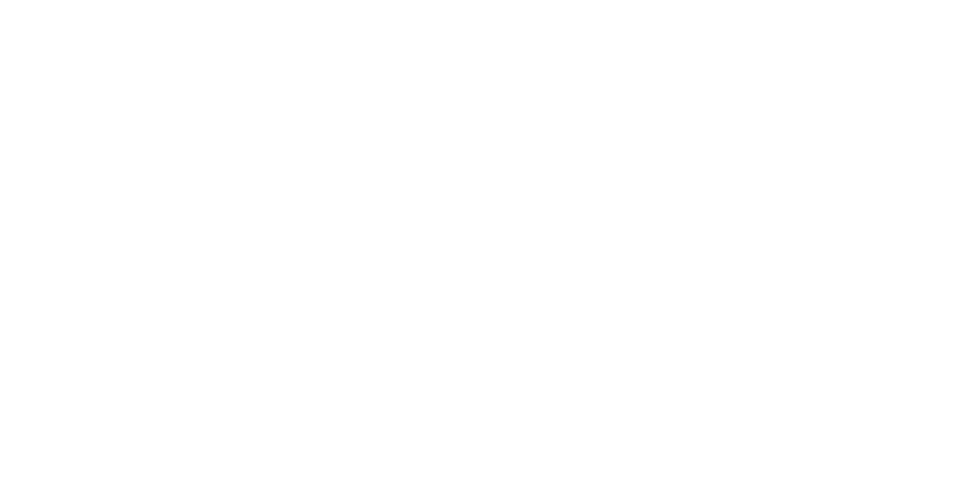

In [19]:
fig8 = plt.figure(figsize=plt.figaspect(0.5)); ax8 = []
#
# Subplot 1 (top) of Figure 1: ground truth
ax8.append(fig8.add_subplot(1, 2, 1, projection='3d'))
surf = ax8[0].plot_surface(X1_grid, X2_grid, Y_grid,
                       cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
#
# Create axis labels and title:
ax8[0].set_xlabel('$x_1$')
ax8[0].set_ylabel('$x_2$')
ax8[0].set_zlabel('$f(x_1,x_2)$')
ax8[0].set_title("Ground truth of %s function" % function_name)
ax8[0].scatter(X_train[:,0], X_train[:,1], y_noisy_train,
               marker='o', color='red', label="training points")
ax8[0].legend(loc='lower left')

# Subplot 2 (bottom) of Figure 1
ax8.append(fig8.add_subplot(1, 2, 2, projection='3d'))
#
y_noisy_data_ANNpred_scaled = history.model.predict(X_data_scaled)
y_noisy_data_ANNpred = scaler_y.inverse_transform(y_noisy_data_ANNpred_scaled) # scaling targets back
Y_grid_noisy_data_ANNpred = np.reshape(y_noisy_data_ANNpred, np.shape(X1_grid))
surf = ax8[1].plot_surface(X1_grid, X2_grid, Y_grid_noisy_data_ANNpred,
                           cmap=set_cm, alpha=0.8,linewidth=0, antialiased=False)
# Create axis labels and title:
ax8[1].set_xlabel('$x_1$')
ax8[1].set_ylabel('$x_2$')
ax8[1].set_zlabel('$f(x_1,x_2)$')
ax8[1].set_title("ANN approximation of %s function" % function_name)
ax8[1].scatter(X_train[:,0], X_train[:,1], y_noisy_train,
               marker='o', color='red', label="training points")
ax8[1].legend(loc='upper center')
#
plt.tight_layout()
plt.close(fig8)

<IPython.core.display.Javascript object>


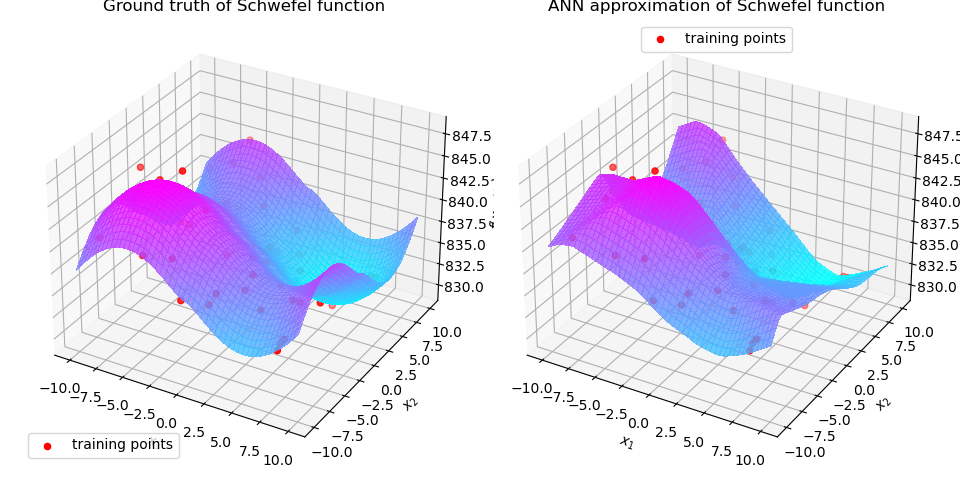

In [20]:
fig8 # plot surfaces for ANN

In [21]:
# Compute R2 for the ANN model
y_noisy_test_ANNpred = history.model.predict(X_test_scaled)
ANN_noisy_r2_value = r2_score(y_noisy_test, scaler_y.inverse_transform(y_noisy_test_ANNpred))
# note the transformation of the outputs back to the original scale

print('R2 score for ANN = ', ANN_noisy_r2_value)

R2 score for ANN =  0.7020248737715156


## Don't forget to "play" with this notebook

* **Try learning different functions**: go to the beginning of the notebook and change the benchmark function to be learned (e.g. Levy function)
* Use different noise levels
* Try different kernels for the GPR
* Do a Grid Search to find better parameters for the ANN
* Investigate the role of "early stopping" in the ANN

There are so many things that you can do to go deeper in the topic! Have some fun with it!

**Important Note:** Despite this notebook being dedicated to 3D surfaces (2 features and 1 target), the algorithms are general. In principle, they can perform regression for any dimensionality of features and targets (although for GPR if you want more than one output you have to consider modifications to the method). The codes do not change significantly, but visualizing data can be a challenge. The simplest solution is to project the space back to a 3D space. You will do that in your projects.

# 2. Multidimensional classification

Here's some good news:

* If you understand regression with supervised learning... Then, performing classification with supervised learning is very similar!

But first: what is classification?

* Classification problems occur when the target (output) is **discrete**, instead of being a continuous variable like we did in regression problems.

* A simple classification problem that is very common to consider when first learning about this topic is the [Iris dataset](http://archive.ics.uci.edu/ml/datasets/Iris) created by UCI researchers in 1936.

* I downloaded the .CSV file from [Kaggle](https://www.kaggle.com/) and it is included in the docs folder of this GitHub repository.

Therefore, we can load that .CSV file into a Pandas DataFrame!

In [22]:
# Load the Iris dataset.
iris_data = pd.read_csv('docs/Iris.csv')

print(iris_data)

      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...            ...           ...            ...           ...   
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris-setosa  
4       Iris-setosa  
..              ...  
145  

#### A short note

In fact, the Iris dataset is **so common**, that scikit-learn already has it saved and it can be loaded directly from the scikit-learn code, as shown below.

In [23]:
# In case you wanted to load the Iris dataset directly from scikit-learn.
from sklearn.datasets import load_iris

iris = load_iris() # load Iris dataset that already exists in Scikit-learn
# Convert it to a Pandas Dataframe
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

# You can print(data1) and see that it is the same dataset.

# But I think it is informative to understand the usual process
# in machine learning: someone gives us a dataset (or we download
# it from somewhere) and we usually load it with Pandas due to its
# versatility.

When you start a new problem, the first step is:

* Get to know the dataset.

What are the features? And the targets? What kind of data preprocessing should we do? What do we know *before* using machine learning tools to analyze the dataset?

<img src="docs/iris_dataset_explanation.png" title="Flower to explain Iris dataset" width="25%" align="right">

Here's a nice image to understand the dataset.

The dataset is quite simple! It has:

* 4 Features (inputs): sepal length, sepal width, petal length, petal width


* 1 Target (output): iris species (3 different species with 50 samples each)

So, the dataset has 150 samples of 3 different species of iris flower (50 samples per species) and each flower has 4 features that characterize it: the length and width of the petal and the sepal (see figure on the right).

**Our task**: Learn from part of the dataset how to classify a new iris flower into one of the 3 species!

Note: This example is straight out of Scikit-learn (but simplified)

In [24]:
# Let's only use the first two features (ignoring the other 2).
X_2d = iris_data.loc[:, ['SepalLengthCm','SepalWidthCm'] ].values # just use 2 inputs (features)
y_string = iris_data.loc[:, 'Species'].values

print('y_string = ',y_string,'\n\n')

y_string =  ['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iri

It's also very common to convert our target (output) data from strings to integers!

In this case we have three discrete target values ('Iris-setosa', 'Iris-versicolor' and 'Iris-virginica') so we can convert to 0, 1 and 2

In [25]:
# Pandas makes this very easy for us. Just one line!
y = pd.Categorical(pd.factorize(y_string)[0])

print('y = ',y)

y =  [0, 0, 0, 0, 0, ..., 2, 2, 2, 2, 2]
Length: 150
Categories (3, int64): [0, 1, 2]


Let's consider one of the simplest supervised learning classification algorithms: **Support Vector Machines**.

Note: we can also do classification with Gaussian Processes and with Artificial Neural Networks. But I just want to show a few other examples of algorithms because you will need to search for algorithms you don't know, understand them and decide if they are applicable or not to your problem of interest.

In [26]:
from sklearn import svm
# we create an instance of SVM and fit out data. We do not scale our data (this dataset is quite simple)
C = 1.0  # SVM regularization parameter
svm_model = svm.SVC(kernel='rbf', gamma=0.7, C=C)

svm_model.fit(X_2d, y)

SVC(gamma=0.7)

<IPython.core.display.Javascript object>


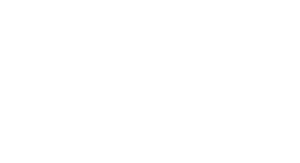

In [27]:
# Set-up 2x2 grid for plotting.
fig9, ax9 = plt.subplots()
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X1, X2 = X_2d[:, 0], X_2d[:, 1]

X1_min, X1_max = X1.min() - 1, X1.max() + 1 # define min and max of feature 0
X2_min, X2_max = X2.min() - 1, X2.max() + 1 # define min and max of feature 1
X1_grid, X2_grid = np.meshgrid(np.arange(X1_min, X1_max, 0.02),
                               np.arange(X2_min, X2_max, 0.02))

y_pred = svm_model.predict(np.c_[X1_grid.ravel(), X2_grid.ravel()])
Y_grid = y_pred.reshape(X1_grid.shape)

ax9.contourf(X1_grid, X2_grid, Y_grid, cmap=cm.coolwarm, alpha=0.8)

ax9.scatter(X1, X2, c=y, cmap=cm.coolwarm, s=20, edgecolors='k')
ax9.set_xlim(X1_grid.min(), X1_grid.max())
ax9.set_ylim(X2_grid.min(), X2_grid.max())
ax9.set_xlabel('Sepal length')
ax9.set_ylabel('Sepal width')
ax9.set_xticks(())
ax9.set_yticks(())
ax9.set_title('SVC with RBF kernel')

plt.close(fig9)

<IPython.core.display.Javascript object>


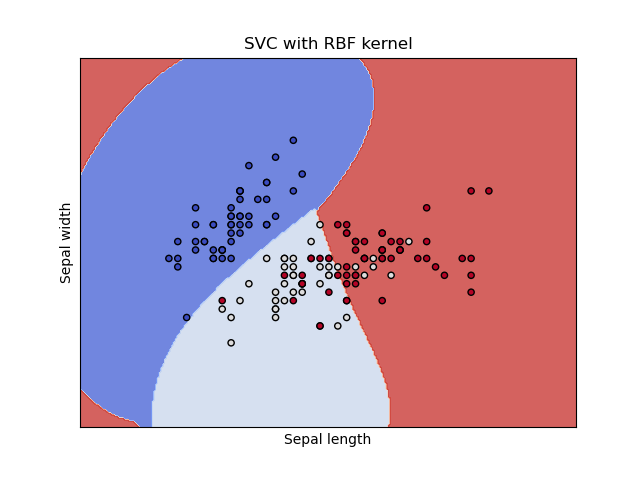

In [28]:
fig9 # classification plot using only 2 features ('SepalLengthCm' and 'SepalWidthCm')

Let's now plot for all 4 features, instead of considering only the first 2.

Let's also use a different classifier. Instead of Support Vector Machines (SVM), we will use **Decision Trees**.

The following is also an example from Scikit-learn.

In [29]:
# Load all the features and the target variables:
X = iris_data.iloc[:, 1:5 ].values # now using all 4 features (inputs)
feature_names = iris_data.columns.values[1:5] # not including the "ID" column

y_strings = iris_data.loc[:, 'Species'].values
target_names = iris_data.loc[:, 'Species'].unique()

print(feature_names)
print(target_names)

['SepalLengthCm' 'SepalWidthCm' 'PetalLengthCm' 'PetalWidthCm']
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


<IPython.core.display.Javascript object>


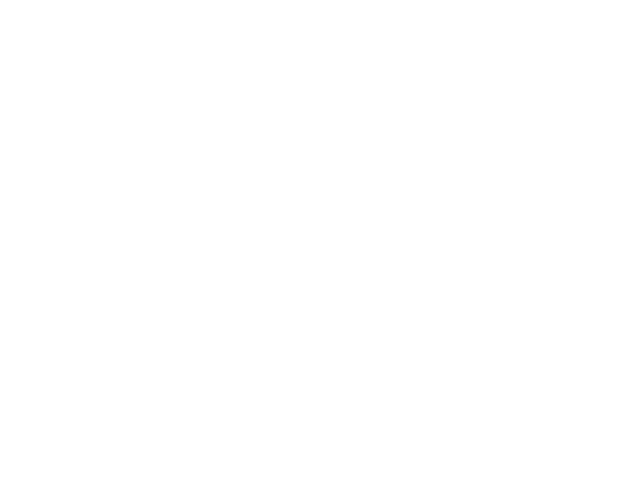

In [30]:
from sklearn.tree import DecisionTreeClassifier
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

fig10, ax10 = plt.subplots() # open figure
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    #X_temp = iris.data[:, pair]
    #y_temp = iris.target

    X_temp = X[:, pair]
    
    # Train
    clf = DecisionTreeClassifier().fit(X_temp, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x1_min, x1_max = X_temp[:, 0].min() - 1, X_temp[:, 0].max() + 1
    x2_min, x2_max = X_temp[:, 1].min() - 1, X_temp[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, plot_step),
                         np.arange(x2_min, x2_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Y = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Y = Y.reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, Y, cmap=cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]])
    plt.ylabel(feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X_temp[idx, 0], X_temp[idx, 1],
                    c=color, label=target_names[i],cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.close(fig10)

<IPython.core.display.Javascript object>


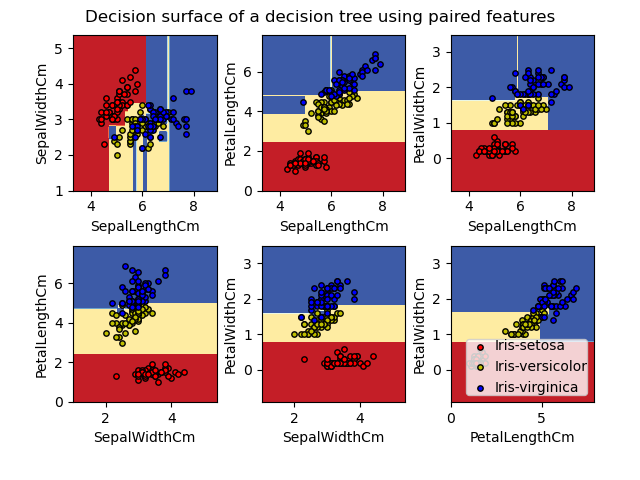

In [31]:
fig10 # classification plot with Decision Trees for all 4 features (showing them in pairs of 2)

### You will explore these and other things in Part 3 of the Midterm Project...

Have fun!